<a href="https://colab.research.google.com/github/Dembelinho/LSTM_TimeSeries/blob/main/Stock_Price_Prediction_LSTM_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


# Loading Data

In [ ]:
# Load historical stock price data from a CSV file
data = pd.read_csv('NFLX.csv')

In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200



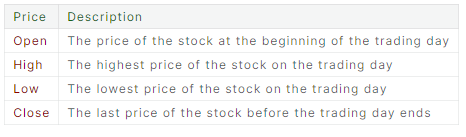





In [ ]:
# Display basic statistics of the dataset
print(data.describe())

              Open         High          Low        Close    Adj Close  \
count  5044.000000  5044.000000  5044.000000  5044.000000  5044.000000   
mean    116.467981   118.237392   114.578719   116.456338   116.456338   
std     168.740876   171.140864   166.119837   168.668232   168.668232   
min       0.377857     0.410714     0.346429     0.372857     0.372857   
25%       3.955357     4.031072     3.885357     3.958571     3.958571   
50%      25.819285    26.342143    25.455000    25.802856    25.802856   
75%     155.762497   157.654998   153.944996   155.869999   155.869999   
max     692.349976   700.989990   686.090027   691.690002   691.690002   

             Volume  
count  5.044000e+03  
mean   1.653068e+07  
std    1.924487e+07  
min    2.856000e+05  
25%    6.168225e+06  
50%    1.059135e+07  
75%    1.986552e+07  
max    3.234140e+08  


In [ ]:
# Check for missing values
print(data.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5044 entries, 0 to 5043
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5044 non-null   object 
 1   Open       5044 non-null   float64
 2   High       5044 non-null   float64
 3   Low        5044 non-null   float64
 4   Close      5044 non-null   float64
 5   Adj Close  5044 non-null   float64
 6   Volume     5044 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 276.0+ KB


In [ ]:
#The date column is an object -----> We will Convert the type of "Date" column into date-time format
data['Date'] = pd.to_datetime(data['Date'])

print (data.dtypes)

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object


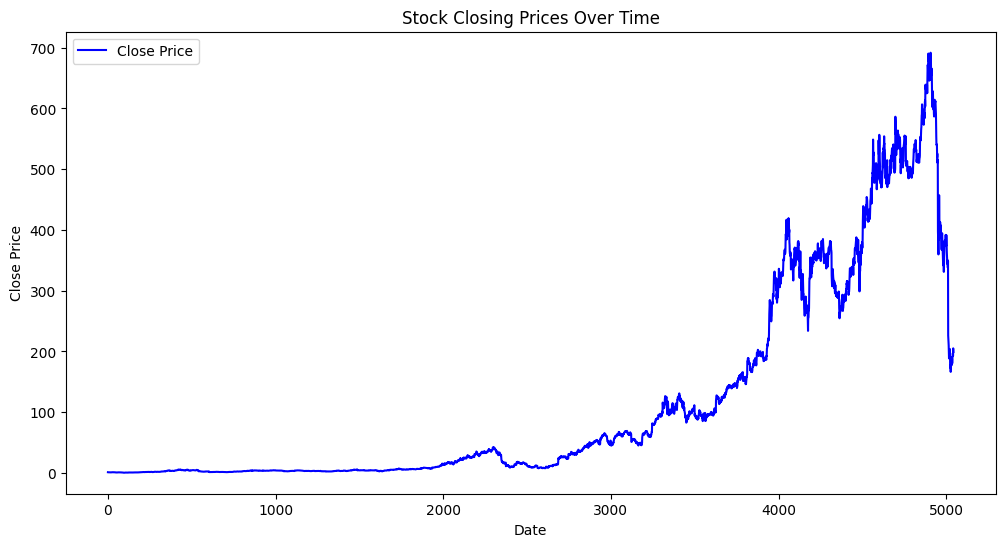

In [ ]:
# Plot the closing price over time
plt.figure(figsize=(12, 6))
plt.title('Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(data['Close'], label='Close Price', color='blue')
plt.legend()
plt.show()


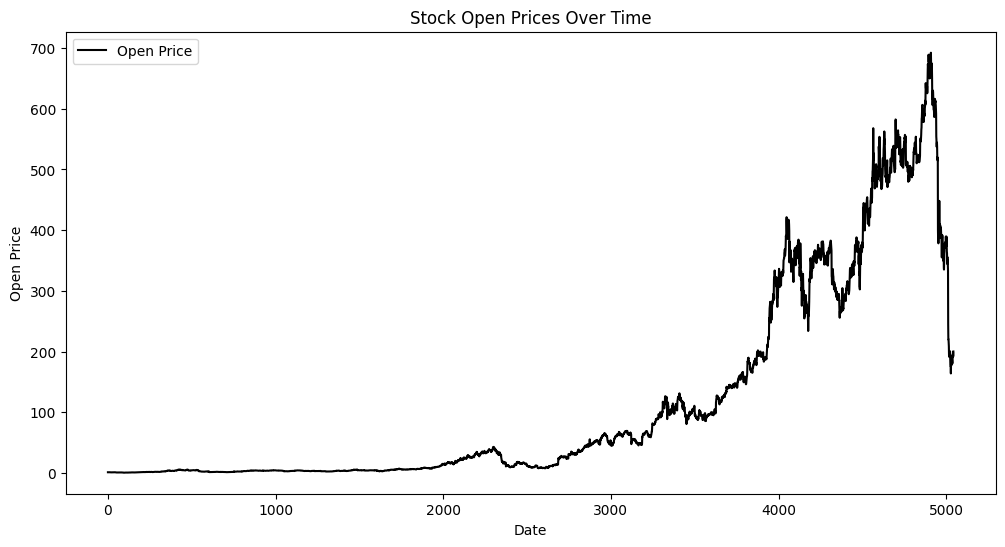

In [ ]:
# Plot 'Open' price feature over time
plt.figure(figsize=(12, 6))
plt.title('Stock Open Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.plot(data['Open'], label='Open Price', color='black')
plt.legend()
plt.show()


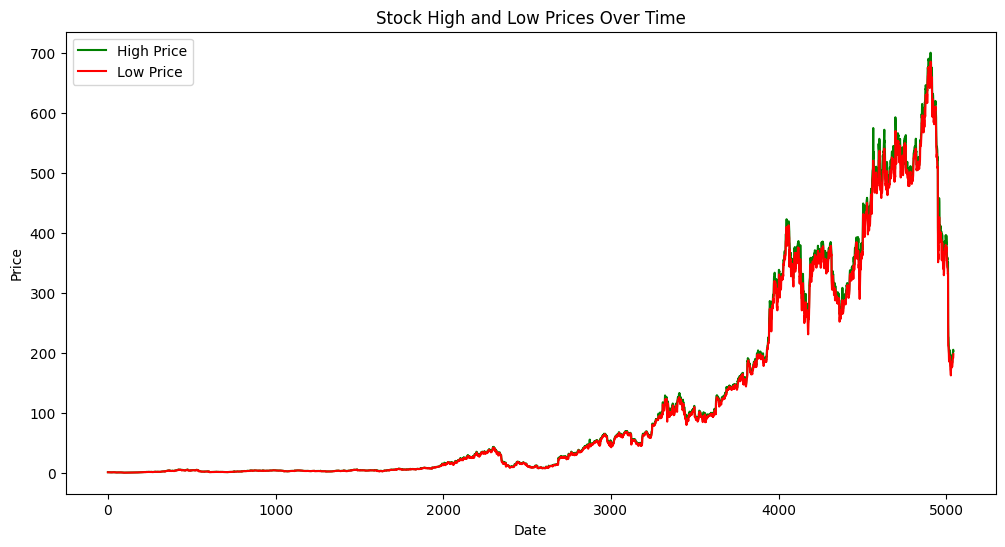

In [ ]:
# Create a plot for High and Low prices over time
plt.figure(figsize=(12, 6))
plt.title('Stock High and Low Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(data.index, data['High'], label='High Price', color='green')
plt.plot(data.index, data['Low'], label='Low Price', color='red')
plt.legend()
plt.show()

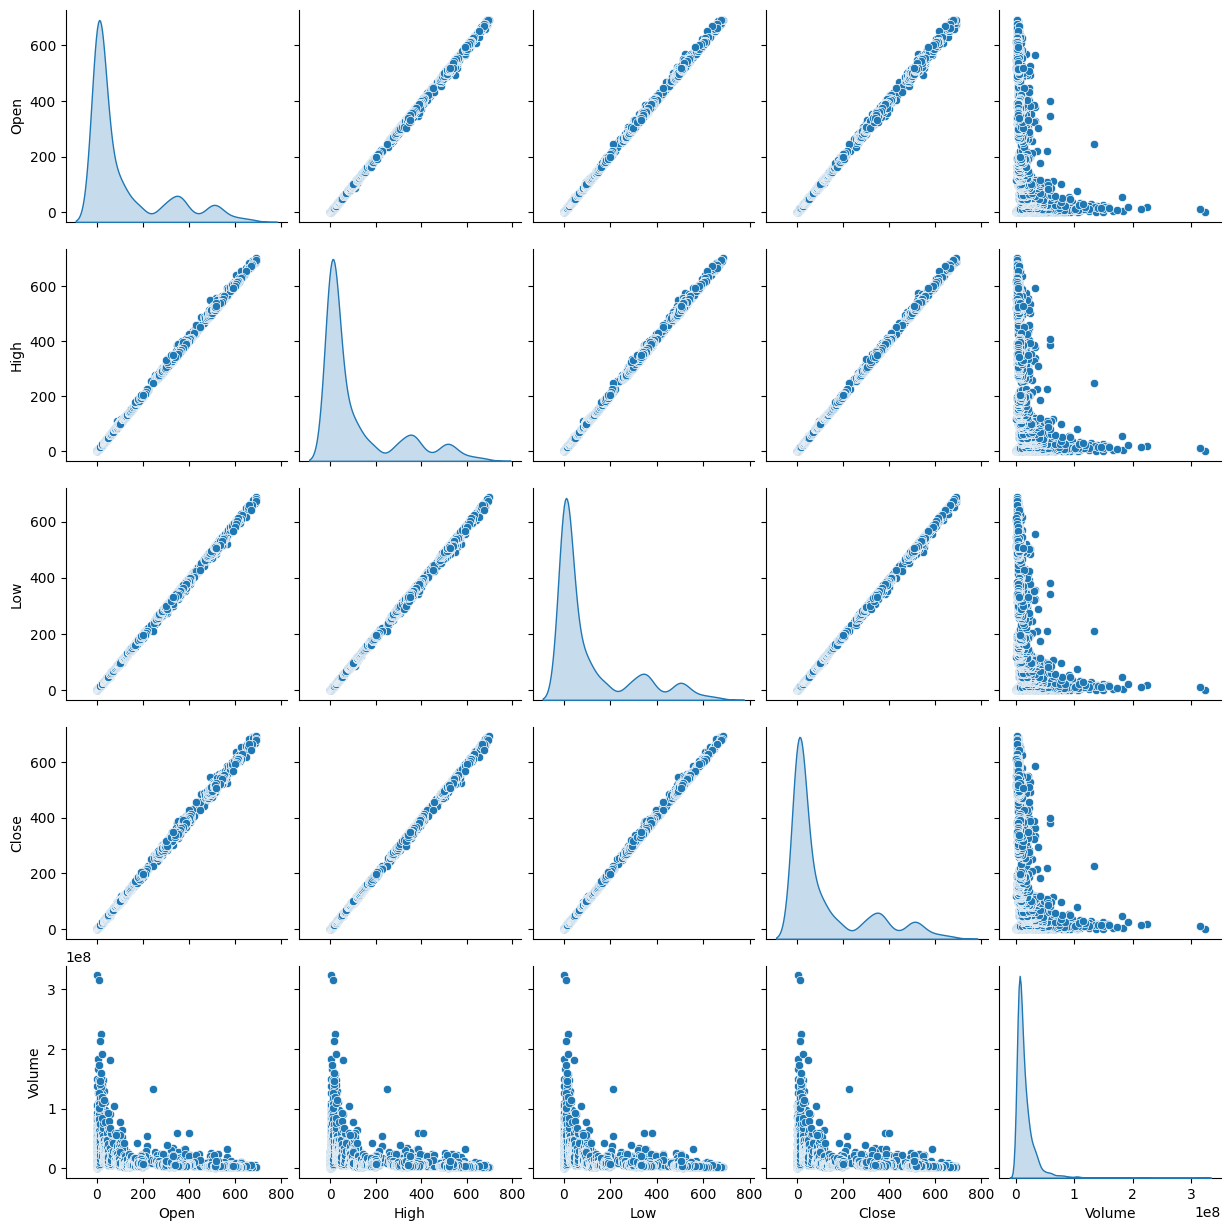

In [ ]:
# Use seaborn to create a pair plot for feature analysis
sns.pairplot(data[['Open', 'High', 'Low', 'Close', 'Volume']], diag_kind='kde')
plt.show()

In [ ]:
# Add the "Year", 'Month' and "Day" columns
data["Year"] = data["Date"].apply(lambda x : str(x)[:4])
data["Month"] = data["Date"].apply(lambda x : str(x)[5:7])
data["Day"] = data["Date"].apply(lambda x : str(x)[8:10])

data.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000,2002,05,23
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800,2002,05,24
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400,2002,05,28


# Feature Extraction

We will select from the dataset the '**Open**' column represents the starting price of the stock for a particular day.

In [ ]:
# Create a new dataframe with only the Open column and convert it into a NumPy array
data = data['Open'].values

# Reshape the data on 1D table such that the total number of elements in the array remains the same
data = data.reshape(-1, 1)

In [ ]:
# Split the data into training and testing sets
dataset_train = np.array(data[:int(data.shape[0]*0.8)])
dataset_test = np.array(data[int(data.shape[0]*0.8):])



*   To produce the best-optimized results, we are required to scale the data.
*   For this task, we are leveraging scikit-learn library’s 'MinMaxScaler()' for converting the input values between 0 to 1.

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1)) #the scaled data will be in the range [0, 1]

dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

We will create the helper function with 50 timesteps. In other words, for the features(x) we'll append the last 50 prices, and for the label(y) we'll append the next price.

In [ ]:
# Create the function that will help us to create the datasets
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
# After that we will convert it into a NumPy array.
    x = np.array(x)
    y = np.array(y)
    return x,y

In [ ]:
# Create the training and testing data by calling our function for each one
x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)

In [ ]:
# Reshape the data to make it a 3D array in order to use it in LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Building Model



*   For the LSTM layer, we add 96 units (neurones)that represent the dimensionality of the output space.
*   The return_sequences parameter is set to True for returning the last output in output.
*   For the Dropout layers, we specify the percentage of layers is 20% that should be dropped.
*   The next step is to add the Dense layer.



In [ ]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2)) #Dropout is a regularization technique used to prevent overfitting in neural networks
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
# Summary of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 96)            37632     
                                                                 
 dropout (Dropout)           (None, 50, 96)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_1 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_2 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_5 (LSTM)               (None, 96)               

We will compile the model with the help of adam optimizer.

Adam combines the benefits of two other extensions of stochastic gradient descent, namely RMSprop and Momentum. It's known for its efficiency and ability to handle a wide range of deep learning tasks. The optimizer is responsible for updating the model's weights during training to minimize the specified loss function

The error is computed using mean_squared_error.

In [ ]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Training Model

In [ ]:
# Define hyperparameters
epochs = 40
batch_size = 64

# Save the model and start the training
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)
model.save('stock_prediction')

Epoch 1/40
63/63 [==============================] - 27s 305ms/step - loss: 0.0025
Epoch 2/40
63/63 [==============================] - 19s 306ms/step - loss: 7.5304e-04
Epoch 3/40
63/63 [==============================] - 19s 306ms/step - loss: 7.8692e-04
Epoch 4/40
63/63 [==============================] - 18s 285ms/step - loss: 6.0581e-04
Epoch 5/40
63/63 [==============================] - 19s 307ms/step - loss: 5.0184e-04
Epoch 6/40
63/63 [==============================] - 18s 289ms/step - loss: 6.0092e-04
Epoch 7/40
63/63 [==============================] - 19s 302ms/step - loss: 5.7057e-04
Epoch 8/40
63/63 [==============================] - 18s 288ms/step - loss: 5.1382e-04
Epoch 9/40
63/63 [==============================] - 18s 293ms/step - loss: 4.7076e-04
Epoch 10/40
63/63 [==============================] - 19s 297ms/step - loss: 4.3730e-04
Epoch 11/40
63/63 [==============================] - 18s 286ms/step - loss: 4.5819e-04
Epoch 12/40
63/63 [==============================] - 19s

In [ ]:
# Load the model
model = load_model('stock_prediction')

# Prediction Model

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)#it's common to inverse transform the predictions to get them back into their original scale
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

30/30 [==============================] - 3s 57ms/step


# Plotting Results

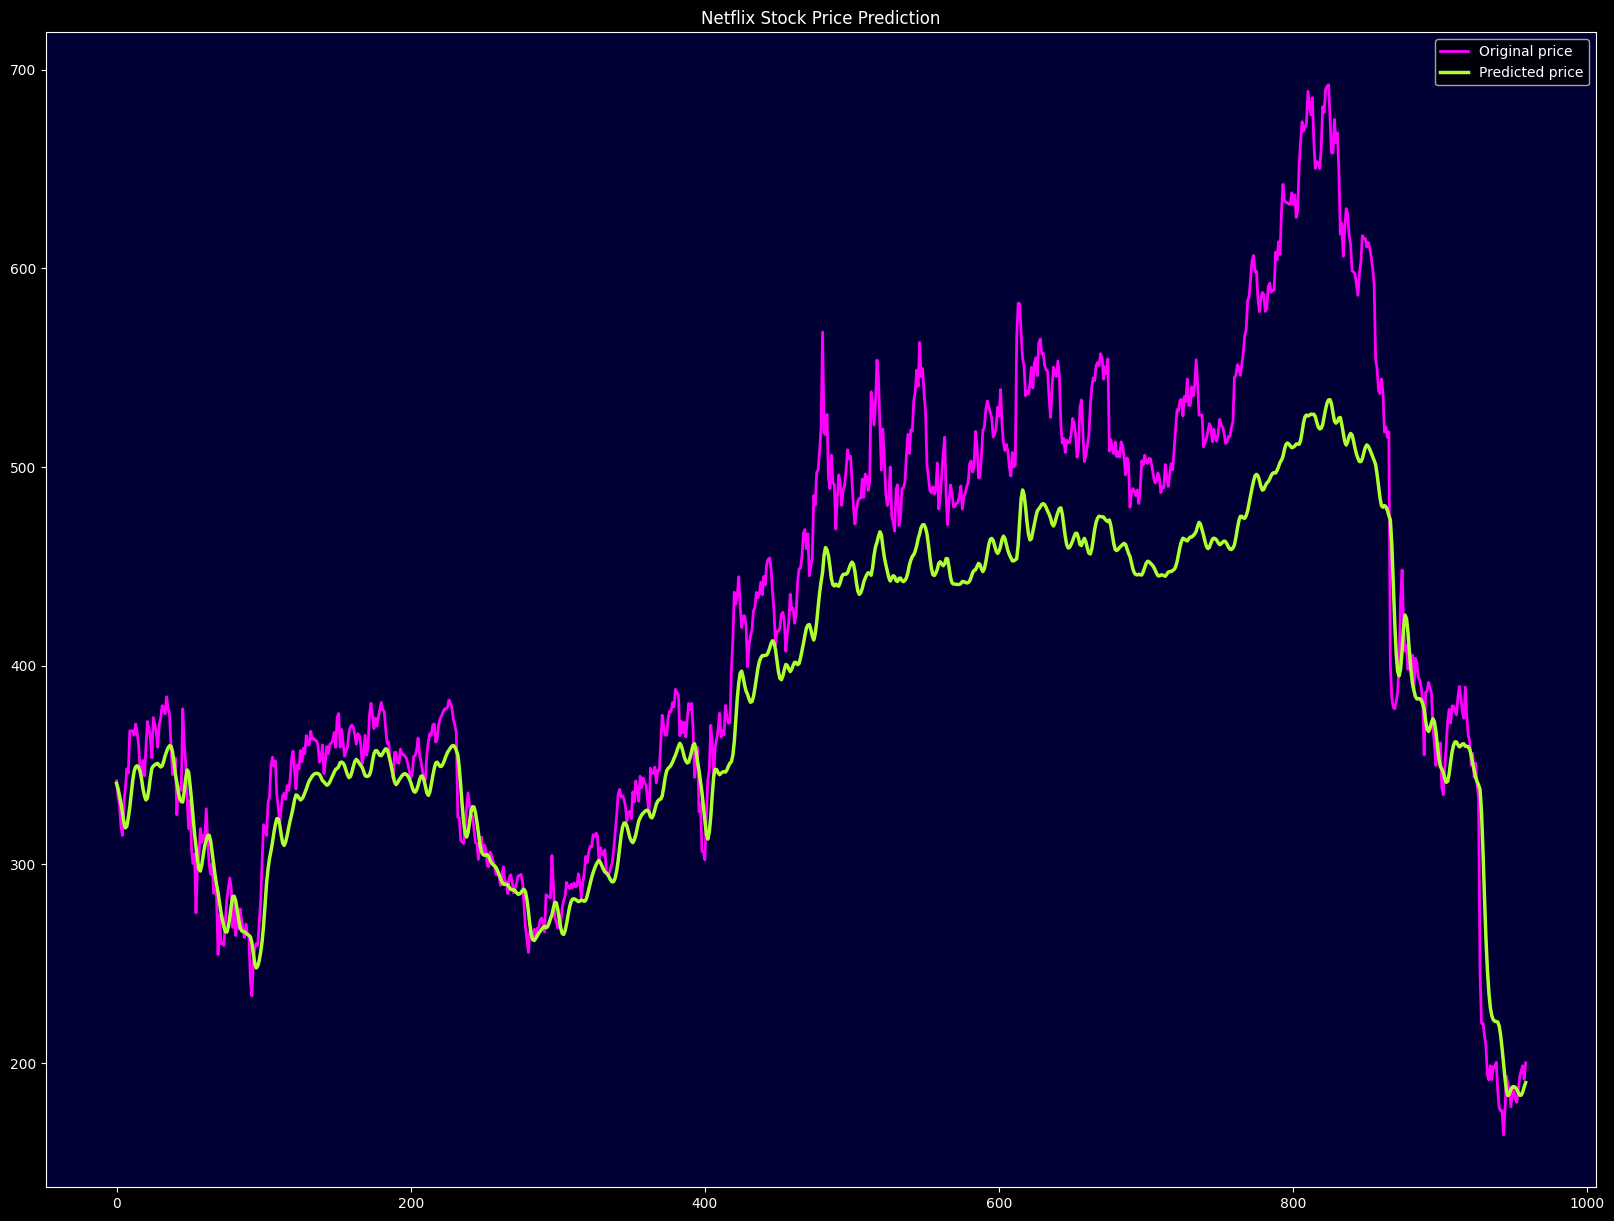

In [ ]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(20,15))
ax.set_facecolor('#000035')
ax.plot(y_test_scaled, color='fuchsia', linewidth=2, label='Original price')
plt.plot(predictions, color='greenyellow', linewidth=2.5, label='Predicted price')
plt.title('Netflix Stock Price Prediction')
plt.legend();